## INTRODUCCIÓN Y DESCRIPCIÓN DEL PROBLEMA

La predicción de series temporales constituye un problema fundamental en múltiples ámbitos, como la meteorología. La capacidad de anticipar valores futuros permite mejorar la toma de decisiones y optimizar distintos procesos.

En esta práctica se aborda un problema de predicción de series temporales utilizando el conjunto de datos Weather Long-term Time Series Forecasting, que recoge observaciones meteorológicas registradas de forma periódica a lo largo del tiempo. El objetivo principal es predecir la temperatura a corto plazo a partir de información histórica.

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [126]:
df = pd.read_csv("cleaned_weather.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52696 entries, 0 to 52695
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      52696 non-null  object 
 1   p         52696 non-null  float64
 2   T         52696 non-null  float64
 3   Tpot      52696 non-null  float64
 4   Tdew      52696 non-null  float64
 5   rh        52696 non-null  float64
 6   VPmax     52696 non-null  float64
 7   VPact     52696 non-null  float64
 8   VPdef     52696 non-null  float64
 9   sh        52696 non-null  float64
 10  H2OC      52696 non-null  float64
 11  rho       52696 non-null  float64
 12  wv        52696 non-null  float64
 13  max. wv   52696 non-null  float64
 14  wd        52696 non-null  float64
 15  rain      52696 non-null  float64
 16  raining   52696 non-null  float64
 17  SWDR      52696 non-null  float64
 18  PAR       52696 non-null  float64
 19  max. PAR  52696 non-null  float64
 20  Tlog      52696 non-null  fl

In [127]:
target_col = "T"

In [128]:
df["date"] = pd.to_datetime(df["date"]) #Convertimos date a tipo datetime

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52696 entries, 0 to 52695
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      52696 non-null  datetime64[ns]
 1   p         52696 non-null  float64       
 2   T         52696 non-null  float64       
 3   Tpot      52696 non-null  float64       
 4   Tdew      52696 non-null  float64       
 5   rh        52696 non-null  float64       
 6   VPmax     52696 non-null  float64       
 7   VPact     52696 non-null  float64       
 8   VPdef     52696 non-null  float64       
 9   sh        52696 non-null  float64       
 10  H2OC      52696 non-null  float64       
 11  rho       52696 non-null  float64       
 12  wv        52696 non-null  float64       
 13  max. wv   52696 non-null  float64       
 14  wd        52696 non-null  float64       
 15  rain      52696 non-null  float64       
 16  raining   52696 non-null  float64       
 17  SWDR      52

In [130]:
df.isna().sum()


date        0
p           0
T           0
Tpot        0
Tdew        0
rh          0
VPmax       0
VPact       0
VPdef       0
sh          0
H2OC        0
rho         0
wv          0
max. wv     0
wd          0
rain        0
raining     0
SWDR        0
PAR         0
max. PAR    0
Tlog        0
dtype: int64

#### No se detectan valores nulos por lo que no es necesario aplicar técnicas de imputación

In [131]:
df.describe()

,date,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,...,rho,wv,max. wv,wd,rain,raining,SWDR,PAR,max. PAR,Tlog
count,52696,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,...,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000
mean,2020-07-02 00:11:52.198269440,989.989233,10.818241,284.796938,5.409105,72.487133,14.487046,9.676828,4.810131,6.111159,...,1210.882855,1.995935,3.632807,176.850276,0.011773,25.907469,131.331822,259.863438,308.601939,21.515206
min,2020-01-01 00:10:00,955.580000,-6.440000,266.190000,-13.810000,21.160000,3.770000,2.090000,0.000000,1.300000,...,1107.380000,-9999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9999.000000,6.900000
25%,2020-04-01 11:47:30,984.800000,4.590000,278.550000,0.777500,58.820000,8.480000,6.460000,1.170000,4.070000,...,1183.900000,1.000000,1.770000,141.100000,0.000000,0.000000,0.000000,0.000000,0.000000,15.240000
50%,2020-07-02 00:45:00,990.920000,10.230000,284.320000,5.260000,75.400000,12.480000,8.890000,2.740000,5.610000,...,1210.800000,1.770000,3.000000,195.500000,0.000000,0.000000,2.820000,9.670000,13.120000,20.440000
75%,2020-10-01 12:22:30,995.930000,16.180000,290.260000,9.700000,87.900000,18.420000,12.050000,6.440000,7.620000,...,1236.550000,2.920000,4.850000,226.700000,0.000000,0.000000,182.900000,366.437500,434.260000,26.822500
max,2021-01-01 00:00:00,1020.070000,34.800000,309.130000,20.500000,100.000000,55.670000,24.160000,42.100000,15.400000,...,1318.520000,13.770000,22.900000,360.000000,11.200000,600.000000,1115.290000,2131.760000,2498.940000,49.090000
std,NaN,9.207149,7.468671,7.616995,5.956722,19.230260,7.632960,4.023504,5.539320,2.561536,...,36.430222,43.596931,2.462467,81.194840,0.123289,111.503420,215.735116,422.786515,569.956762,7.790620


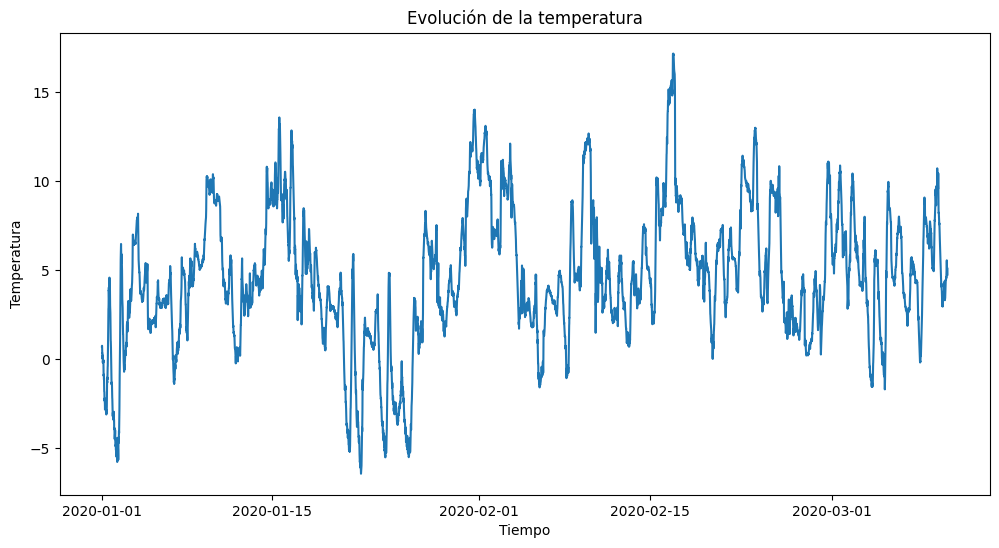

In [132]:
plt.figure(figsize=(12,6))
plt.plot(
    df["date"][:10000],          #Usamos el slice para ver la evolucion de los primeros 1000 registros
    df[target_col][:10000]
)
plt.title("Evolución de la temperatura")
plt.xlabel("Tiempo")
plt.ylabel("Temperatura")
plt.show()


In [133]:
features = df.drop(columns=[target_col, "date"])
target = df[target_col]

En esta sección se ha realizado la carga y análisis exploratorio del dataset Weather Long-term Time Series Forecasting. El conjunto de datos contiene aproximadamente 52.695 observaciones temporales con 21 variables.

La variables objetivo seleccionada es la tempertatura (T), que será la variable a predecir. El análisis visual muestra una clara estructura temporal con posibles patrones estacionales.

No se han detectado valores nulos y los rangos de las variables justifican la necesidad de normalizar el dataset.

## Preprocesado

In [134]:
X = features
y = target

Se separan las variables predictoras de la variable objetivo para aplicar el preprocesado de forma independiente

In [135]:
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))  #Porque StandadScaler espera una matriz 2D

In [136]:
X_scaled = np.array(X_scaled)
y_scaled = np.array(y_scaled)

In [137]:
print("Media X (primeras 5 variables):", X_scaled.mean(axis=0)[:5])
print("Std X (primeras 5 variables):", X_scaled.std(axis=0)[:5])

print("Media y:", y_scaled.mean())
print("Std y:", y_scaled.std())



Media X (primeras 5 variables): [ 7.68037692e-16  1.11322317e-15 -4.31481850e-17 -1.63963103e-16
  8.62963699e-17]
Std X (primeras 5 variables): [1. 1. 1. 1. 1.]
Media y: -2.5888910973496893e-16
Std y: 1.0


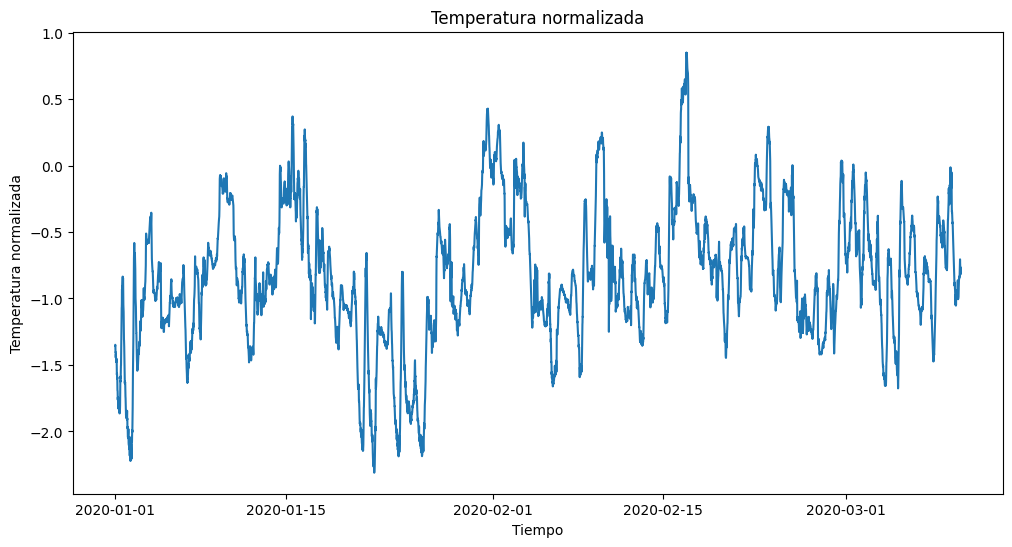

In [138]:
plt.figure(figsize=(12,6))
plt.plot(df["date"][:10000], y_scaled[:10000])
plt.title("Temperatura normalizada")
plt.xlabel("Tiempo")
plt.ylabel("Temperatura normalizada")
plt.show()

En esta sección se ha llevado a cabo el preprocesado del conjunto de datos. En primer lugar, se han separado las variables predictoras de la variable objetivo (Temperatura).

Dado que las distintas variables presentan rangos y escalas diferentes, se ha aplicado una normalización mediante StandardScaler, garantizando media 0 y desviación estándar 1, tanto en las variables de entrada como en la variable objetivo.

Este preprocesado es fundamental para asegurar una correcta y estable convergencia de los modelos de deep learning que se emplearán en las siguientes fases del proyecto.

## Construcción del dataset temporal

El dataset original contiene observaciones independientes correspondientes a instantes temporales individuales. Sin embargo, para abordar un problema de predicción temporal es necesario transformar el conjunto de datos en un formato secuencial, donde cada muestra incorpore información de múltiples pasos temporales anteriores. 

Para ello, se emplea una estrategia de ventana deslizante (aliding window), que permite capturar la dependencia temporal entre observaciones.

In [139]:
w = 4   #Tamaño de ventana
h = 1   #Horizonte de predicción

Se define una ventana temporal de tamaño w=4 y un horizonte de predicción h=1, como se indica en el enunciado de la práctica

In [140]:
def create_sliding_windows(X, y, w, h=1):
    X_windows = []
    y_windows = []

    for i in range(len(X) - w - h + 1):
        X_windows.append(X[i:i+w])          #Ventana de entrada
        y_windows.append(y[i+w:i+w+h])      #Valor futuro a predecir

    return np.array(X_windows), np.array(y_windows)

In [141]:
X_temporal, y_temporal = create_sliding_windows(X_scaled, y_scaled, w, h)

In [142]:
print("Shape de X:", X_temporal.shape)
print("Shape de y:", y_temporal.shape)

Shape de X: (52692, 4, 19)
Shape de y: (52692, 1, 1)


In [143]:
sample_idx = 0

print("Entrada (X):")
print(X_temporal[sample_idx])

print("\nSalida (y):")
print(y_temporal[sample_idx])


Entrada (X):
[[ 2.05285544 -1.52514843 -1.13135522  0.70789454 -1.05556979 -1.02817523
  -0.70769854 -1.05061344 -1.0513627   1.91428441 -0.02238562 -0.82552433
   0.58439889 -0.09549337 -0.23234906 -0.60877001 -0.61465041 -0.54145312
  -1.29197696]
 [ 2.03873584 -1.51989697 -1.14982193  0.66109286 -1.05294955 -1.04060233
  -0.69686678 -1.06232527 -1.06116027  1.90632391 -0.03591881 -1.13416088
   0.36886591 -0.09549337 -0.23234906 -0.60877001 -0.61465041 -0.54145312
  -1.28427532]
 [ 2.02787462 -1.52120984 -1.15653709  0.65589267 -1.05425967 -1.04308775
  -0.69506149 -1.06232527 -1.06605906  1.90522591 -0.03179004 -0.87425642
   0.24939906 -0.09549337 -0.23234906 -0.60877001 -0.61465041 -0.54145312
  -1.27272285]
 [ 2.02570237 -1.56716015 -1.18339776  0.71829492 -1.07653171 -1.06048568
  -0.71311442 -1.07794105 -1.08075541  1.9513419  -0.02032123 -0.87425642
   0.36393944 -0.09549337 -0.23234906 -0.60877001 -0.61465041 -0.54145312
  -1.25988678]]

Salida (y):
[[-1.40431153]]


Cada muestra contiene una secuencia de w observaciones (En este caso 4) consecutivas que se emplean para predecir el siguiente valor de la temperatura

In [144]:
X_mlp = X_temporal.reshape(X_temporal.shape[0], -1)
print(X_mlp.shape)

(52692, 76)


Para abordar el problema de predicción temporal, el conjunto de datos se ha transformado mediante una estrategia de ventana deslizante (sliding window). Cada muestra de entrada está compuesta por una secuencia de w observaciones consecutivas, a partir de las cuales se predice el valor de la temperatura en el siguiente instante temporal (h=1).

Esta transformación permite capturar la dependencia temporal de los datos y es necesario tanto para el entrenamiento del baseline basado en un perceptrón multicapa como para los modelos secuenciales propuestos posteriormente.

## Baseline

In [145]:
n_samples = X_mlp.shape[0]

train_end = int(0.7*n_samples)
val_end = int(0.85*n_samples)

X_train = X_mlp[:train_end]
y_train = y_temporal[:train_end]

X_val = X_mlp[train_end:val_end]
y_val = y_temporal[train_end:val_end]

X_test = X_mlp[val_end:]
y_test = y_temporal[val_end:]

El conjunto de datos se divide respetando el orden temporal para evitar fuga de información entre los distintos subconjuntos

#### Conversión a tensores

In [146]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

#### DataLoaders

In [147]:
batch_size = 8

train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),
    batch_size=batch_size,
    shuffle=False
)

val_loader = DataLoader(
    TensorDataset(X_val_t, y_val_t),
    batch_size=batch_size,
    shuffle=False
)

#### Definición del modelo MLP

In [148]:
class MLPBaseline(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 1)

    def forward(self, x): 
        x = self.relu(self.fc1(x))
        return self.fc2(x)
        

#### Entrenamiento

In [149]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=100, patience=5):
    best_val_loss = np.inf
    patience_counter = 0
    best_state = model.state_dict()

    for epoch in range(epochs):
        #Entrenamiento
        model.train()
        train_loss = 0.0
        for Xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(Xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)

        #Validación
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for Xb, yb in val_loader:
                preds = model(Xb)
                loss = criterion(preds, yb)
                val_loss += loss.item()

            val_loss /= len(val_loader)

            print(f"Epoch {epoch+1}: Train = {train_loss:.4f}, Val={val_loss:.4f}")

            #Early stopping
            if val_loss < best_val_loss: 
                best_val_loss = val_loss
                best_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping activado")
                    break

        model.load_state_dict(best_state)
        return model, best_val_loss
            


#### Buscamos el mejor learning rate

In [150]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]

best_lr = None
best_val = np.inf
best_model = None

input_size = X_mlp.shape[1]
criterion = nn.MSELoss()

for lr in learning_rates:
    print(f"\nEntrenando con Learning rate: {lr}")

    model = MLPBaseline(input_size)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    model, val_loss = train_model(
        model,
        train_loader,
        val_loader,
        optimizer,
        criterion,
    )

    if val_loss < best_val:
        best_val = val_loss
        best_lr = lr
        best_model = model



Entrenando con Learning rate: 0.1
Epoch 1: Train = nan, Val=nan

Entrenando con Learning rate: 0.01
Epoch 1: Train = 0.0386, Val=0.4432

Entrenando con Learning rate: 0.001
Epoch 1: Train = 0.0190, Val=0.0092

Entrenando con Learning rate: 0.0001
Epoch 1: Train = 0.0974, Val=0.0250


#### Evaluacion en test

In [151]:
best_model.eval()
with torch.no_grad():
    y_pred_mlp = best_model(X_test_t).detach().cpu().numpy()

y_test_mlp_t = y_test_t
y_test_np = y_test_mlp_t.numpy()

mae_mlp = mean_absolute_error(y_test_np, y_pred_mlp)
rmse_mlp = np.sqrt(mean_squared_error(y_test_np, y_pred_mlp))

print(f"MAE MLP: {mae_mlp}")
print(f"RMSE MLP: {rmse_mlp}")

MAE MLP: 0.07740769535303116
RMSE MLP: 0.09845673547241364


Como modelo baseline se ha implementado un Perceptrón Multicapa con una única capa oculta de 100 neuronas, siguiendo las especificaciones del enunciado. Se ha empleado el optimizador SGD y un tamaño de batch de 8. 

Se ha realizado una búsqueda del mejor learning rate, seleccionando el modelo con menor error de validación. Además, se ha aplicado early stopping con una paciencia de 5 épocas y se ha conservado el mejor modelo según el conjunto de validación. 

## LSTM

In [152]:
n_samples = X_temporal.shape[0]

train_end = int(0.7 * n_samples)
val_end = int(0.85 * n_samples)

X_train_lstm = X_temporal[:train_end]
y_train_lstm = y_temporal[:train_end]

X_val_lstm = X_temporal[train_end:val_end]
y_val_lstm = y_temporal[train_end:val_end]

X_test_lstm = X_temporal[val_end:]
y_test_lstm = y_temporal[val_end:]

#### Conversión a tensores

In [153]:
X_train_t = torch.tensor(X_train_lstm, dtype=torch.float32)
y_train_t = torch.tensor(y_train_lstm, dtype=torch.float32).view(-1, 1)

X_val_t = torch.tensor(X_val_lstm, dtype=torch.float32)
y_val_t = torch.tensor(y_val_lstm, dtype=torch.float32).view(-1, 1)

X_test_t = torch.tensor(X_test_lstm, dtype=torch.float32)
y_test_t = torch.tensor(y_test_lstm, dtype=torch.float32).view(-1, 1)

#### DataLoaders

In [154]:
batch_size = 8

train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),
    batch_size=batch_size,
    shuffle = False
)

val_loader = DataLoader(
    TensorDataset(X_val_t, y_val_t),
    batch_size=batch_size,
    shuffle=False
)

#### Definición del modelo LSTM

In [155]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

#### Entrenamiento de la LSTM

In [156]:
input_size = X_temporal.shape[2]    #numero de variables
criterion = nn.MSELoss()

model_lstm = LSTMModel(
    input_size=input_size,
    hidden_size=64,
    num_layers=1
)

optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)

# Entrenamiento
model_lstm, best_val_lstm = train_model(
    model_lstm, 
    train_loader, 
    val_loader,
    optimizer,
    criterion,
    epochs=100,
    patience=5
)


Epoch 1: Train = 0.0215, Val=0.0044


#### Evaluación en test

In [157]:
model_lstm.eval()

with torch.no_grad():
    y_pred_lstm4 = model_lstm(X_test_t).detach().cpu().numpy()

y_test_lstm4_t = y_test_t
y_test_np = y_test_lstm4_t.numpy()

mae_lstm4 = mean_absolute_error(y_test_np, y_pred_lstm4)
rmse_lstm4 = np.sqrt(mean_squared_error(y_test_np, y_pred_lstm4))

print(f"MAE LSTM (w=4): {mae_lstm4}")
print(f"RMSE LSTM (w=4): {rmse_lstm4}")

MAE LSTM (w=4): 0.16034556925296783
RMSE LSTM (w=4): 0.19604621402224387


Como propuesta avanzada se ha implementado una red LST, para modelar explícitamente las dependencias temporales del problema. A diferencia del baseline, la LSTM recibe como entrada secuencias temporales completas sin necesidad de aplanarlas, permitiendo capturar patrones dinámicos y estacionales.

El modelo se ha entrenado utilizando el optimizador Adam y early stopping, manteniendo el mismo conjunto de test que el baseline para garantizar una comparación justa.

## LSTM con ventana temporal ampliada

In [158]:
w_lstm = 24
h = 1

X_temporal_24, y_temporal_24 = create_sliding_windows(
    X_scaled, y_scaled, w_lstm, h
)

y_temporal_24 = y_temporal_24.squeeze()


In [159]:
n_samples = X_temporal_24.shape[0]

train_end = int(0.7 * n_samples)
val_end = int(0.85 * n_samples)

X_train = X_temporal_24[:train_end]
y_train = y_temporal_24[:train_end]

X_val = X_temporal_24[train_end:val_end]
y_val = y_temporal_24[train_end:val_end]

X_test = X_temporal_24[val_end:]
y_test = y_temporal_24[val_end:]


#### Conversión a tensores + DataLoaders

In [160]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),
    batch_size=8,
    shuffle=False
)

val_loader = DataLoader(
    TensorDataset(X_val_t, y_val_t),
    batch_size=8,
    shuffle=False
)


#### LSTM mejorada

In [161]:
input_size = X_temporal_24.shape[2]
criterion = nn.MSELoss()

model_lstm_24 = LSTMModel(
    input_size=input_size,
    hidden_size=128,
    num_layers=1
)

optimizer = torch.optim.Adam(model_lstm_24.parameters(), lr=0.001)

model_lstm_24, best_val_24 = train_model(
    model_lstm_24,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    epochs=100,
    patience=5
)


Epoch 1: Train = 0.0177, Val=0.0049


#### Evaluación

In [162]:
model_lstm_24.eval()
with torch.no_grad():
    y_pred_lstm24 = model_lstm_24(X_test_t).detach().cpu().numpy()

y_test_lstm24_t = y_test_t
mae_lstm24 = mean_absolute_error(y_test_lstm24_t.numpy(), y_pred_lstm24)
rmse_lstm24 = np.sqrt(mean_squared_error(y_test_lstm24_t.numpy(), y_pred_lstm24))

print(f"MAE LSTM (w=24): {mae_lstm24}")
print(f"RMSE LSTM (w=24): {rmse_lstm24}")


MAE LSTM (w=24): 0.18686287105083466
RMSE LSTM (w=24): 0.2206416761887763


Se observa que el aumento del tamaño de ventana temporal empeora el rendimiento de la red LSTM, lo que indica que el modelo no es capaz de beneficiarse de un mayor contexto temporal. Este comportamiento sugiere que la dinámica local de la temperatura puede ser capturada eficazmente por modelos más simples, y pone de manifiesto que una mayor complejidad arquitectónica no garantiza necesariamente un mejor rendimiento.

## Comparación de resultados

In [163]:
results = pd.DataFrame({
    "Modelo": [
        "Baseline MLP (w=4)",
        "LSTM (w=4)",
        "LSTM (w=24)"
    ],
    "MAE": [
        mae_mlp,
        mae_lstm4,
        mae_lstm24
    ],
    "RMSE": [
        rmse_mlp,
        rmse_lstm4,
        rmse_lstm24
    ]
})

results.round(4)


,Modelo,MAE,RMSE
0,Baseline MLP (w=4),0.0774,0.0985
1,LSTM (w=4),0.1603,0.1960
2,LSTM (w=24),0.1869,0.2206


## Análisis de resultados

A partir de la tabla de resultados de la parte superior, se observa que el modelo baseline MLP obtiene el mejor rendimiento en términos de MAE y RMSE, superando a las propuestas basadas en redes recurrentes (LSTM).

El perceptrón multicapa, a pesar de ser un modelo más simple, logra capturar eficazmente la dinámica temporal local del problema utilizando una ventana de tamaño reducido (w=4). Esto sugiere que la temperatura a corto plazo depende en gran medida de observaciones recientes, y que un modelo no secuencial es suficiente para modelar dicha relación.

Por otro lado, las redes LSTM no logran mejorar el rendimiento del baseline. Esto pone de manifiesto que la mayor capacidad de modelado de las redes recurrentes no siempre se traduce en mejores resultados cuando el problema presenta una estructura relativamente sencilla.

Los resultados obtenidos refuerzan la idea de que un modelo más complejo no garantiza necesariamente un mejor rendimiento. En este caso, el baseline presenta una mejor relación entre complejidad y capacidad predictiva.

Algunas posibles líneas de mejora futuras podrían ser:  
* Incrementar el horizonte de predicción (h>1)
* Evaluar otras arquitecturas recurrentes (GRU)
* Incorporar self attention
* Aplicar selección de características

## Demostración visual

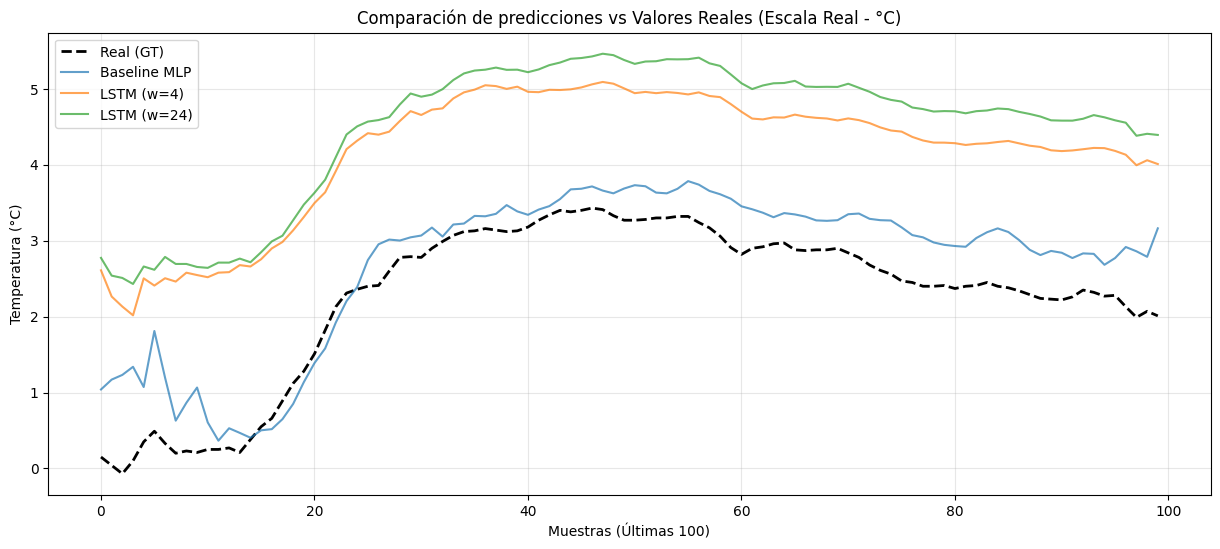

In [164]:
# Invertimos el escalado para visualizar en grados reales
y_test_real = scaler_y.inverse_transform(y_test_mlp_t.numpy())
y_pred_mlp_real = scaler_y.inverse_transform(y_pred_mlp)
y_pred_lstm4_real = scaler_y.inverse_transform(y_pred_lstm4)
y_pred_lstm24_real = scaler_y.inverse_transform(y_pred_lstm24)

# Visualización de resultados (últimas 100 muestras)
plt.figure(figsize=(15, 6))
subset = 100

plt.plot(y_test_real[-subset:], label='Real (GT)', color='black', linewidth=2, linestyle='--')
plt.plot(y_pred_mlp_real[-subset:], label='Baseline MLP', alpha=0.7)
plt.plot(y_pred_lstm4_real[-subset:], label='LSTM (w=4)', alpha=0.7)
plt.plot(y_pred_lstm24_real[-subset:], label='LSTM (w=24)', alpha=0.7)

plt.title('Comparación de predicciones vs Valores Reales (Escala Real - °C)')
plt.xlabel('Muestras (Últimas 100)')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()